# Test Real Data on Dataset 1
This notebook tests real-world sensor data collected from an Android phone against a pre-loaded Human Activity Recognition (HAR) Dataset 1. It processes phone sensor data to match the dataset's format and evaluates compatibility for on-device training or inference. Key tasks include:
- Defining utility functions for reading sensor data, plotting (using Plotly and Matplotlib), checking sampling rates, converting data to Dataset 1 format, and taking subsets.
- Loading and preprocessing HAR Dataset 1 by dropping unnecessary columns (e.g., AG, RV, cos).
- Reading real sensor data from CSV files (accelerometer, gravity, gyroscope, orientation) collected via an [Android Logger](https://github.com/tszheichoi/awesome-sensor-logger).
- Analyzing sampling rates and plotting variations in sampling gaps for each sensor.
- Processing real data to align with Dataset 1 structure, including axis adjustments and concatenation.
- Creating subsets of real data and preparing a test DataFrame with a fixed activity label (e.g., 'Running').
- Optionally splitting the real data into train/test sets and saving as client data for experiments (commented out).
The goal is to validate and integrate personal Android-collected HAR data with existing datasets for preliminary testing and model evaluation.

In [1]:
import sys
import dataloading
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import plotly.graph_objects as go
import seaborn as sns
from scipy.spatial.transform import Rotation

### Usefull functions

In [2]:
def read_android_logger_sensor_data(path_to_sensor_data):
    def safe_read(filename):
        file_path = os.path.join(path_to_sensor_data, filename)
        if os.path.exists(file_path):
            return pd.read_csv(file_path)
        else:
            print(f"Warning: {filename} not found.")
            return None

    acc_df = safe_read("Accelerometer.csv")
    ag_df = safe_read("gravity.csv")
    rot_rate_df = safe_read("Gyroscope.csv")
    orientation_df = safe_read("Orientation.csv")

    return acc_df, ag_df, rot_rate_df, orientation_df

In [3]:
def pretty_plot(df):
    fig = go.Figure()
    for axis in ['x', 'y', 'z']:
        fig.add_trace(go.Scatter(x = df.index, y = df[axis], name = axis))
    fig.show()

In [4]:
# check sampling rate
def check_sampling_rate(df):
    consecutive_deltas = df['seconds_elapsed'].diff()
    avg_sampling_rate = 1 / np.mean(consecutive_deltas)
    shortest_gap = np.min(consecutive_deltas)
    maximum_gap = np.max(consecutive_deltas)
    total_num_of_samples = len(df.index)

    print(f"Total Samples: {total_num_of_samples}")
    print(f"Average Sampling Rate: {avg_sampling_rate:.2f} Hz")
    print(f"Shortest Sampling Gap: {shortest_gap:.5f} s")
    print(f"Maximum Sampling Gap: {maximum_gap:.5f} s")

    plt.figure(figsize=(10, 5))
    plt.plot(consecutive_deltas, marker="o", linestyle="-", alpha=0.6)
    plt.xlabel("Sample Index")
    plt.ylabel("Time Between Samples (seconds)")
    plt.title("Variation in Sampling Gaps")
    plt.grid(True)
    plt.show()

In [5]:
# mapping {AG, acc, Gravity, RR, to_euler(RV), cos} => {_, acc_df, ag_df, rot_rate_df, orientation_df, _}
def to_data1_df(acc_df, ag_df, rot_rate_df, orientation_df):
    # first try it without rotational vector
    #dfs = [acc_df[['x', 'y', 'z']],ag_df[['x', 'y', 'z']], rot_rate_df[['x', 'y', 'z']]]
    # it seems that ours AG(x,y,z) is dataset's 1 AG(x,z,-y)
    ag_df_dataset_1 = ag_df.copy()
    ag_df_dataset_1['y'] = ag_df['z']
    ag_df_dataset_1['z'] = -ag_df['y']
    dfs = [acc_df[['x', 'y', 'z']],ag_df_dataset_1[['x', 'y', 'z']], rot_rate_df[['x', 'y', 'z']]]
    

    # Find the minimum number of samples
    min_samples = min(len(df) for df in dfs)

    # Trim each DataFrame to the minimum length
    balanced_df_list = [df.iloc[:min_samples] for df in dfs] 
    balanced_df = pd.concat(balanced_df_list, axis = 1)
    
    return balanced_df

In [6]:
def take_df_subset(df, s, e):
    n = len(df)
    start = int(n * s)
    end = int(n * (1 - e))    
    return df.iloc[start:end]

### Load Data 1

In [7]:
df = dataloading.load_data1()
df = df.drop(columns=['cos'])
df = df.drop(columns=['AG-X'])
df = df.drop(columns=['AG-Y'])
df = df.drop(columns=['AG-Z'])
df = df.drop(columns=['RV-X'])
df = df.drop(columns=['RV-Y'])
df = df.drop(columns=['RV-Z'])

In [8]:
df.head()

Acc-X     Acc-Y     Acc-Z  Gravity-X  Gravity-Y  Gravity-Z      RR-X  \
0 -1.684995  0.401508  1.334339  -8.855526   4.199663  -0.335983 -0.762366   
1 -0.895032 -1.936677  1.436671  -8.399648   5.060810   0.067106 -0.613229   
2  2.350318 -3.642859 -1.169414  -7.911231   5.790931   0.218930 -0.142383   
3  0.812825 -0.722664 -0.334024  -7.523226   6.280006   0.364660 -0.148775   
4  0.349670 -0.468074 -0.378780  -6.921238   6.909286   0.727059 -1.047857   

       RR-Y      RR-Z activity  
0 -0.750471  1.109060  Running  
1 -0.121966  1.906942  Running  
2 -0.352063  1.759936  Running  
3 -0.382955  1.208129  Running  
4  0.379773  0.828895  Running

In [9]:
X_train,y_train,X_test,y_test,labels = dataloading.train_test_split(df,test_size=0.2)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (75358, 9), y_train: (75358,), X_test: (18840, 9), y_test: (18840,)


In [10]:
# client_data = dataloading.to_client(data=(X_train,y_train,X_test,y_test),max_clients=1)
# dataloading.save_client_data(client_data,"dataset_1_real_experiment_2")

### raw data preprocessing

In [8]:
filename = "2025-02-12_21-47-00"
data_path = "/Users/admin/Desktop/" + filename
acc_df, gravity_df, rot_rate_df, orientation_df = read_android_logger_sensor_data(data_path)
acc_df.index = pd.to_datetime(acc_df['time'], unit = 'ns')

In [9]:
acc_df.head()

time  seconds_elapsed         z  \
time                                                                            
2025-02-12 21:47:00.238958000  1739396820238958000         0.012958 -0.352433   
2025-02-12 21:47:00.318924800  1739396820318924800         0.092925 -0.079813   
2025-02-12 21:47:00.398891800  1739396820398891800         0.172892  0.048048   
2025-02-12 21:47:00.478858800  1739396820478858800         0.252859  0.455856   
2025-02-12 21:47:00.558825700  1739396820558825700         0.332826 -0.799913   

                                      y         x  
time                                               
2025-02-12 21:47:00.238958000  0.471985 -0.064492  
2025-02-12 21:47:00.318924800  0.446594  0.249424  
2025-02-12 21:47:00.398891800  0.902948  0.043812  
2025-02-12 21:47:00.478858800  1.974128 -0.655006  
2025-02-12 21:47:00.558825700  1.714152 -5.465285

In [10]:
fig = go.Figure()
for axis in ['x', 'y', 'z']:
    fig.add_trace(go.Scatter(x = acc_df.index, y = acc_df[axis], name = axis))
fig.show()

Total Samples: 395
Average Sampling Rate: 12.51 Hz
Shortest Sampling Gap: 0.07997 s
Maximum Sampling Gap: 0.07997 s


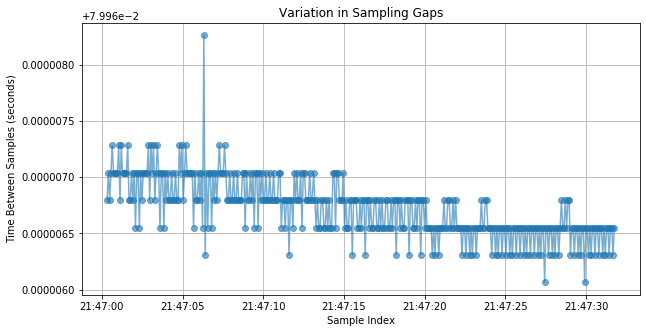

In [41]:
check_sampling_rate(acc_df)

In [43]:
# next we need to interpolate the data
# next we need to smooth and denoise the data

In [50]:
filename = "2025-02-15_13-20-20"
data_path = "/Users/admin/Desktop/" + filename
acc_df, ag_df, rot_rate_df, orientation_df = read_android_logger_sensor_data(data_path)
acc_df.index = pd.to_datetime(acc_df['time'], unit = 'ns')

In [83]:
pretty_plot(acc_df)

In [62]:
filename = "2025-02-15_13-36-18"
data_path = "/Users/admin/Desktop/" + filename
acc_df, ag_df, rot_rate_df, orientation_df = read_android_logger_sensor_data(data_path)
acc_df.index = pd.to_datetime(acc_df['time'], unit = 'ns')
ag_df.index = pd.to_datetime(ag_df['time'], unit = 'ns')

[[1.         0.81410766]
 [0.81410766 1.        ]]


<Figure size 432x288 with 0 Axes>

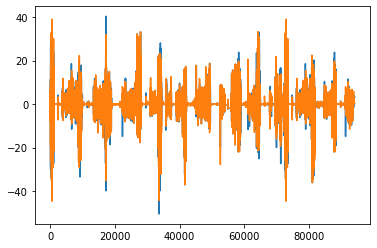

In [110]:
ag_x = df['AG-X'].to_numpy()
gravity_x = df['Gravity-X'].to_numpy()
acc_x = df['Acc-X'].to_numpy()

# AG is not acceleration due to gravity as dataset notes say. gravity is acceleration due to gravity
# AG might be the total acceleration and acc might be the linear acceleration

plt.figure()
# plt.plot(ag_x)
# plt.plot(gravity_x)
# plt.plot(acc_x)

# test if ag is the total acceleration
computed_acc_x = ag_x - gravity_x
plt.figure()
plt.plot(acc_x)
plt.plot(computed_acc_x)


pearsons_cor = np.corrcoef(linear, acc_x)
print(pearsons_cor)

# the computed linear acceleration has strong correletion with the assumed to be
# the measured linear acceleration. maybe some of this data has occured from some type
# of sensor fusion of preprocessing

In [200]:
# so to test our own collected data on dataset1 trained data
# mapping {AG, acc, Gravity, RR, to_euler(RV), cos} => {_, acc_df, ag_df, rot_rate_df, orientation_df, _}

In [112]:
rv_x = df['RV-X'].to_numpy()

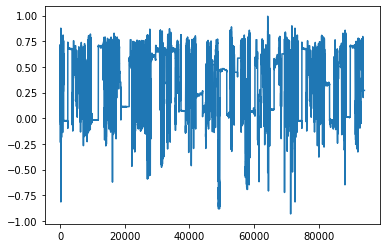

In [113]:
plt.plot(rv_x)

In [116]:
# we need to check if by rotational vector what the dataset really means is the 3D space position
# in roll pitch yaw representation
data_path = "/Users/admin/Desktop/" + "2025-02-12_21-47-00"
acc_df, ag_df, rot_rate_df, orientation_df = read_android_logger_sensor_data(data_path)

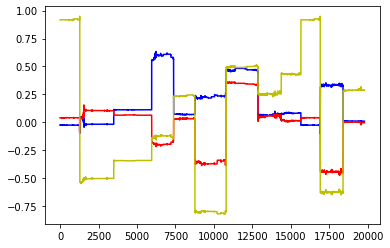

In [165]:
sitting_train_data = df[df['activity'] == 'Sitting']
rv_x = sitting_train_data['RV-X'].to_numpy()
rv_y = sitting_train_data['RV-Y'].to_numpy()
rv_z = sitting_train_data['RV-Z'].to_numpy()

plt.plot(rv_x, color='b')
plt.plot(rv_y, color='r')
plt.plot(rv_z, color='y')

# as you seen we have value [-1,1] so these are indeed
# rotational vectors. We may need to transform RV to roll, pitch, yaw
# or the reverse. i think on transformation may be results to NaN values
# since we have the roll, pitch, yaw mapping problem (something with the locking etc)
# pitch = orientation_df['pitch'].to_numpy()

In [197]:
# convert rotational matrix to roll, pitch, yaw
rotation_matrix = np.concatenate((rv_x.reshape(-1,1), rv_y.reshape(-1,1), rv_z.reshape(-1,1)), axis=1)
rotation = Rotation.from_rotvec(rotation_matrix)
euler_angles = rotation.as_euler('xyz', degrees=False) * np.pi
euler_angles_deg = np.degrees(euler_angles)

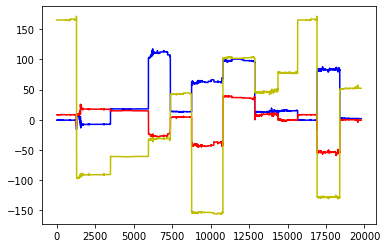

In [198]:
plt.plot(euler_angles_deg[:,0], color='b')
plt.plot(euler_angles_deg[:,1], color='r')
plt.plot(euler_angles_deg[:,2], color='y')

In [22]:
df.head(2)

Acc-X     Acc-Y     Acc-Z  Gravity-X  Gravity-Y  Gravity-Z      RR-X  \
0 -1.684995  0.401508  1.334339  -8.855526   4.199663  -0.335983 -0.762366   
1 -0.895032 -1.936677  1.436671  -8.399648   5.060810   0.067106 -0.613229   

       RR-Y      RR-Z activity  
0 -0.750471  1.109060  Running  
1 -0.121966  1.906942  Running

### Test sitting
drop rotational vector from training. if everything works fine then we will check what is the
right conversion between our roll, pitch, yaw representation and between theirs rotation vector representation

In [24]:
data_path = "/Users/admin/Desktop/" + "2025-02-12_21-47-00"

acc_df, gravity_df, rot_rate_df, orientation_df = read_android_logger_sensor_data(data_path)
to_dataset1_df = to_data1_df(acc_df, gravity_df, rot_rate_df, orientation_df)
raw_data = to_dataset1_df.to_numpy()
print(raw_data.shape)

label_type = 'Sitting'
real_labels = np.full((raw_data.shape[0]), label_type)
test_df = pd.concat([pd.DataFrame(raw_data), pd.DataFrame({'activity':real_labels})], axis=1)

(395, 9)


In [25]:
test_df.head()

0         1         2         3         4         5         6  \
0 -0.064492  0.471985 -0.352433  7.202235  4.876314  4.529876 -0.670051   
1  0.249424  0.446594 -0.079813  6.778457  4.765383  5.245382 -0.473110   
2  0.043812  0.902948  0.048048  6.366938  4.715490  5.778982 -0.437158   
3 -0.655006  1.974128  0.455856  6.035187  4.424329  6.338155 -0.579237   
4 -5.465285  1.714152 -0.799913  6.134382  3.426646  6.840895 -0.708667   

          7         8 activity  
0  0.123437  0.647014  Sitting  
1  0.321044  0.560329  Sitting  
2  0.153132  0.681103  Sitting  
3 -0.066712  0.767123  Sitting  
4 -0.510528  0.561660  Sitting

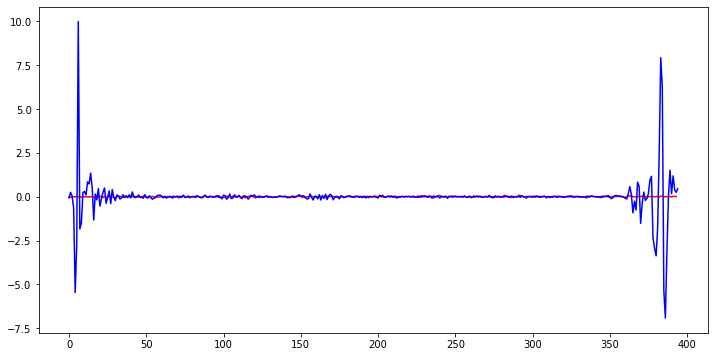

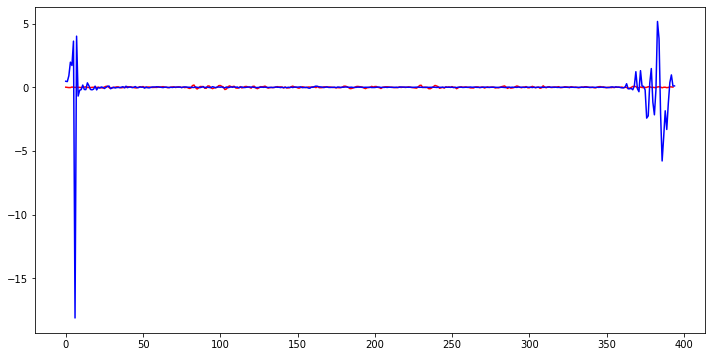

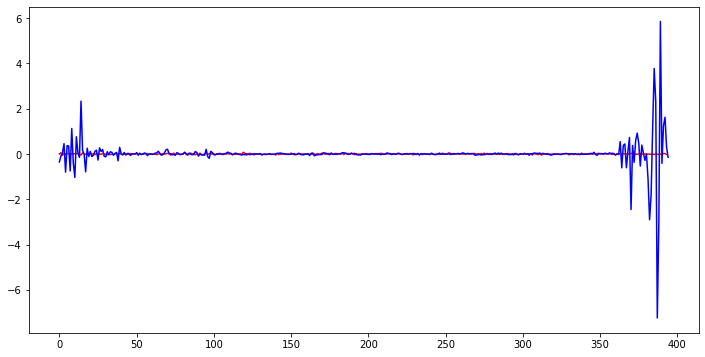

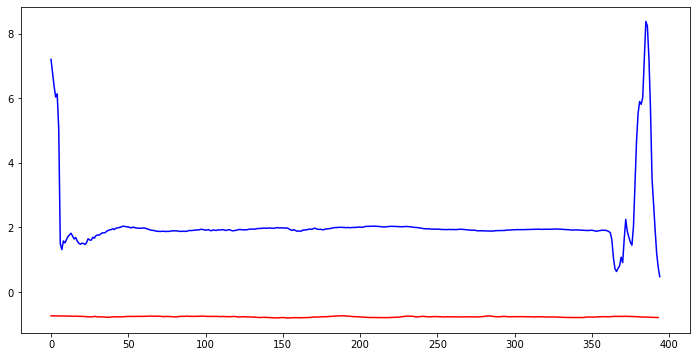

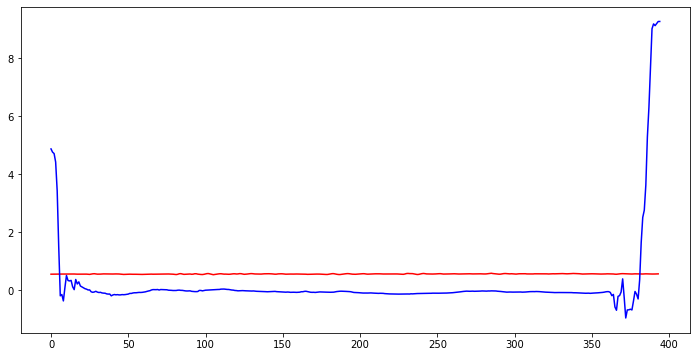

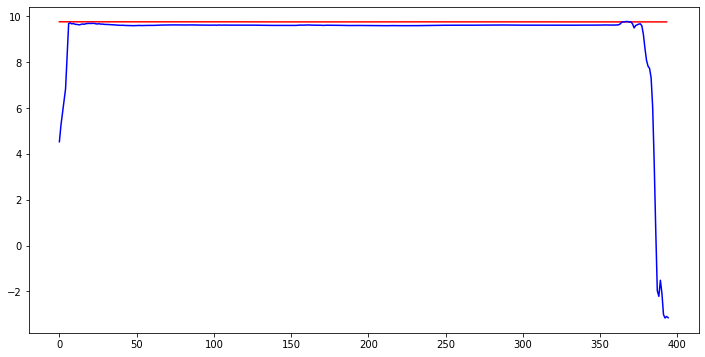

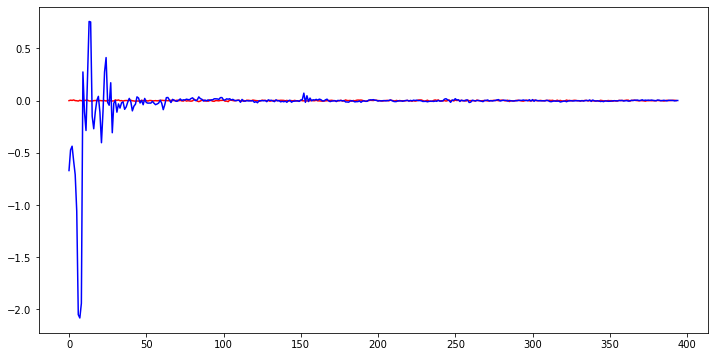

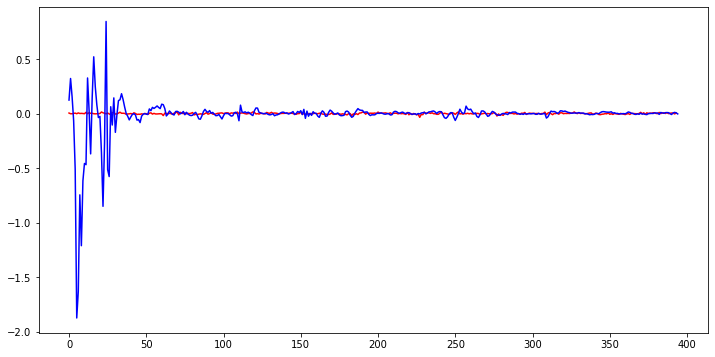

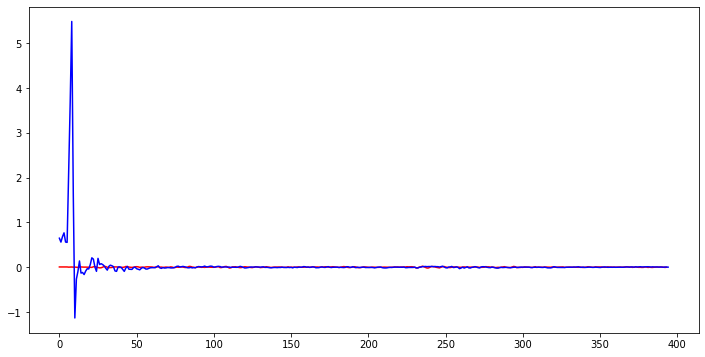

In [26]:
walking_data = df[df['activity'] == 'Sitting'].to_numpy()
real_data = np.copy(raw_data)


for idx in range(X_train.shape[1]):
    plt.figure(figsize=[12,6])
    plt.plot(walking_data[1:real_data.shape[0], idx], color='r')
    plt.plot(real_data[:, idx], color='b')

In [27]:
X_train_real, y_train_real, X_test_real, y_test_real,labels = dataloading.train_test_split(test_df,test_size=0.99, scaler_type="standard")
print(f"X_train: {X_train_real.shape}, y_train: {y_train_real.shape}, X_test: {X_test_real.shape}, y_test: {y_test_real.shape}")

client_data = dataloading.to_client(data=(X_train,y_train,X_test_real,y_test_real),max_clients=1)
dataloading.save_client_data(client_data,"dataset_1_real_experiment_4")

X_train: (3, 9), y_train: (3,), X_test: (392, 9), y_test: (392,)


In [28]:
# train set accuracy: 0.9, test set accuray: 0.52
# the last conversion we tested seems to be right
# mapping from sensor_logger to dataset1
# {AG, acc, Gravity, RR, to_euler(RV), cos} => {_, acc_df, ag_df, rot_rate_df, orientation_df, _}
# AG appeared to be the total acceleration not the acceleration due to gravity so we drop it
# linear acceleration has 1 to 1 mapping
# rotational rate has no 1 to 1 mapping even if the measurments are from an android device
# maybe there was some type of preprocessing: the mapping is RR(x,y,z) <=> rot_rate(x, z, -y)
# rotational_vector / orientation => unknown

# No we will try to bump the accuracy on sitting
# A1. discard the boundaries of the samples to exclude the experiments set up time
# A2. resample the data
# A3. denoise the data
# A4. we discarded the rotational vector from this dataset. try to match it with our own roll, pitch, yaw

# then we should try
# B1. test walking data
# B2. could we also try the other 4 datasets?
# B3. try getting good results from dataset 6
# B4. how hard could it be to collect our own data?

In [52]:
# we will discart 15% of every tail of the dataset
data_path = "/Users/admin/Desktop/" + "2025-02-12_21-47-00"

acc_df, gravity_df, rot_rate_df, orientation_df = read_android_logger_sensor_data(data_path)
test2 = to_data1_df(take_df_subset(acc_df, 0.15, 0.15), take_df_subset(gravity_df, 0.15, 0.15), take_df_subset(rot_rate_df, 0.15, 0.15), take_df_subset(orientation_df, 0.15, 0.15))
raw_data = test2.to_numpy()
print(raw_data.shape)

label_type = 'Sitting'
real_labels = np.full((raw_data.shape[0]), label_type)
test_df = pd.concat([pd.DataFrame(raw_data), pd.DataFrame({'activity':real_labels})], axis=1)

(311, 9)


In [53]:
X_train_real, y_train_real, X_test_real, y_test_real,labels = dataloading.train_test_split(test_df,test_size=0.99, scaler_type="standard")
print(f"X_train: {X_train_real.shape}, y_train: {y_train_real.shape}, X_test: {X_test_real.shape}, y_test: {y_test_real.shape}")

client_data = dataloading.to_client(data=(X_train,y_train,X_test_real,y_test_real),max_clients=1)
dataloading.save_client_data(client_data,"dataset_1_real_experiment_5")
# we got to 0.55 accuracy

X_train: (3, 9), y_train: (3,), X_test: (308, 9), y_test: (308,)


### Lets try the walking sample

In [12]:
data_path = "/Users/admin/Desktop/" + "2025-02-12_19-52-05"

acc_df, gravity_df, rot_rate_df, orientation_df = read_android_logger_sensor_data(data_path)
test3 = to_data1_df(take_df_subset(acc_df, 0.15, 0.15), take_df_subset(gravity_df, 0.15, 0.15), take_df_subset(rot_rate_df, 0.15, 0.15), take_df_subset(orientation_df, 0.15, 0.15))
raw_data = test3.to_numpy()
print(raw_data.shape)

label_type = 'Walking'
real_labels = np.full((raw_data.shape[0]), label_type)
test_df = pd.concat([pd.DataFrame(raw_data), pd.DataFrame({'activity':real_labels})], axis=1)

(302, 9)


In [13]:
X_train_real, y_train_real, X_test_real, y_test_real,labels = dataloading.train_test_split(test_df,test_size=0.99, scaler_type="standard")
print(f"X_train: {X_train_real.shape}, y_train: {y_train_real.shape}, X_test: {X_test_real.shape}, y_test: {y_test_real.shape}")

client_data = dataloading.to_client(data=(X_train,y_train,X_test_real,y_test_real),max_clients=1)
dataloading.save_client_data(client_data,"dataset_1_real_experiment_7")
# 0.98% !! accuracy on the real test set
# are you sure there is not a bug????
# i was waiting lower accuracy score since now that we have walking data
# we have more information and the classification problem is more difficult
# but this seems not to be a problem since our data is aligned with the training data (??)

# so there is a question. which activity is simpler to learn?
# we need a confusion matrix

X_train: (3, 9), y_train: (3,), X_test: (299, 9), y_test: (299,)


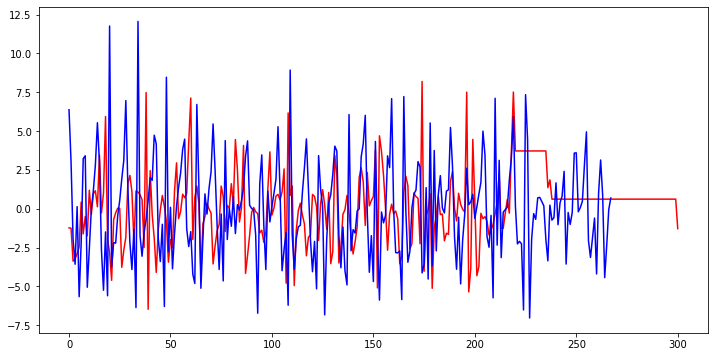

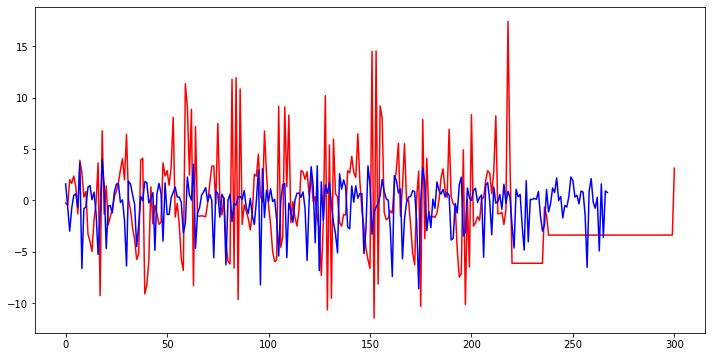

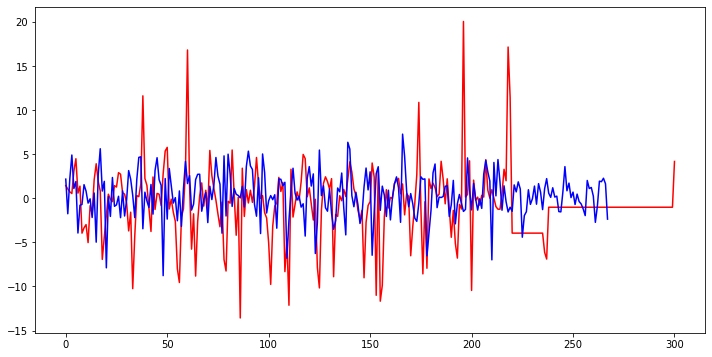

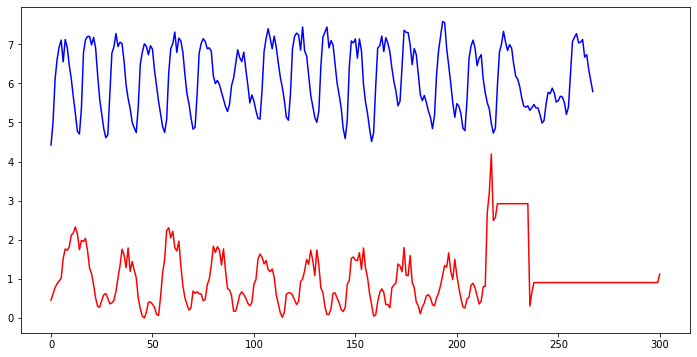

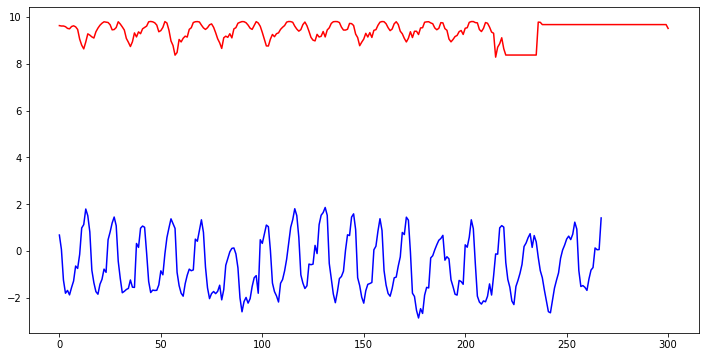

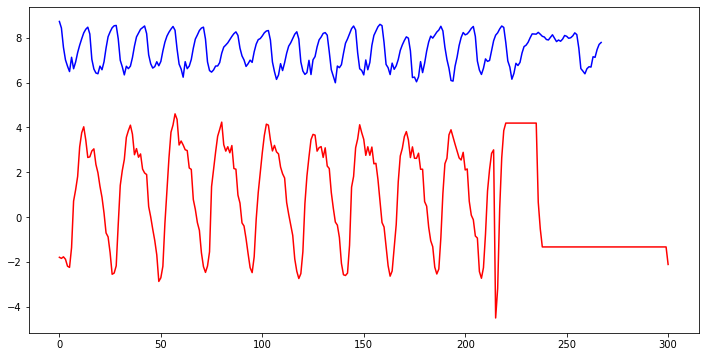

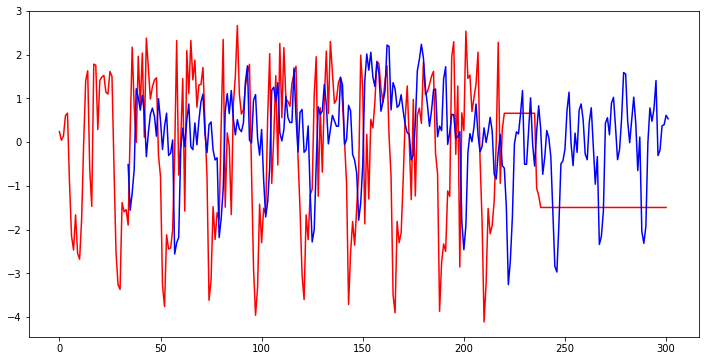

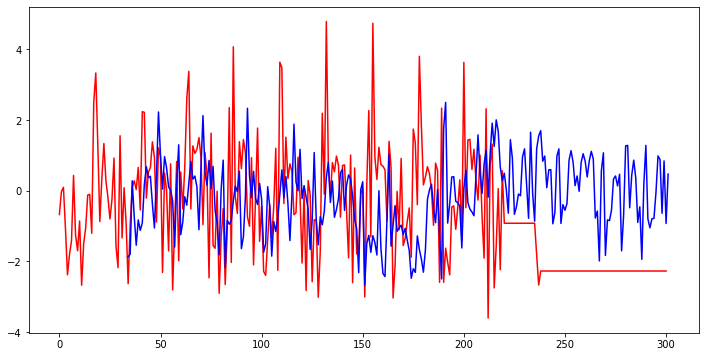

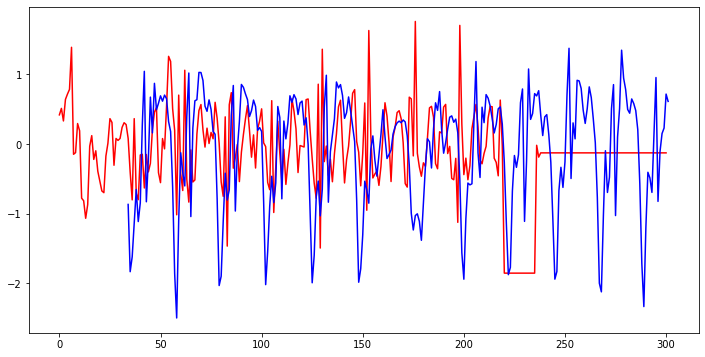

In [14]:
walking_data = df[df['activity'] == 'Walking'].to_numpy()
real_data = np.copy(raw_data)


for idx in range(X_train.shape[1]):
    plt.figure(figsize=[12,6])
    plt.plot(walking_data[1:real_data.shape[0], idx], color='r')
    plt.plot(real_data[:, idx], color='b')

### Try running

In [43]:
data_path = "/Users/admin/Desktop/sensors/data/" + "running_1"

acc_df, gravity_df, rot_rate_df, orientation_df = read_android_logger_sensor_data(data_path)
test3 = to_data1_df(take_df_subset(acc_df, 0.15, 0.15), take_df_subset(gravity_df, 0.15, 0.15), take_df_subset(rot_rate_df, 0.15, 0.15), take_df_subset(orientation_df, 0.15, 0.15))
raw_data = test3.to_numpy()
print(raw_data.shape)

label_type = 'Running'
real_labels = np.full((raw_data.shape[0]), label_type)
test_df = pd.concat([pd.DataFrame(raw_data), pd.DataFrame({'activity':real_labels})], axis=1)

(185, 9)


In [44]:
# X_train_real, y_train_real, X_test_real, y_test_real,labels = dataloading.train_test_split(test_df,test_size=0.99, scaler_type="standard")
# print(f"X_train: {X_train_real.shape}, y_train: {y_train_real.shape}, X_test: {X_test_real.shape}, y_test: {y_test_real.shape}")

# client_data = dataloading.to_client(data=(X_train,y_train,X_test_real,y_test_real),max_clients=1)
# dataloading.save_client_data(client_data,"dataset_1_real_experiment_9")
# # 0.99% accuracy (check if there is a bug)

In [45]:
test_df.head()

0         1         2         3         4         5   6   7   8  \
0  0.523959  5.152969  0.045109 -3.081804  0.133389  9.308871 NaN NaN NaN   
1 -3.921912 -6.716311 -0.503391 -4.636338  1.065086  8.575566 NaN NaN NaN   
2  2.829566 -5.679969 -3.941795 -4.510708  0.707886  8.678871 NaN NaN NaN   
3 -1.091446  4.029707  0.692675 -2.888483 -0.514185  9.357492 NaN NaN NaN   
4 -1.632740  3.314614  3.004692 -2.806233 -0.460821  9.385259 NaN NaN NaN   

  activity  
0  Running  
1  Running  
2  Running  
3  Running  
4  Running